### Library import

In [2]:
import sys
import os
import serial
import csv
import time
import pandas as pd
import functools
import numpy as np
import random as rd
import matplotlib
import threading
from numpy import diff
import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,3)
import helpers

In [3]:
#---- CNN model libraries ----
import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import callbacks
from keras import backend as K
from keras.models import load_model

import object_location

2025-09-21 12:43:10.928953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
plt.rcParams["figure.figsize"] = (20,3)

### Functions

In [5]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Data capture

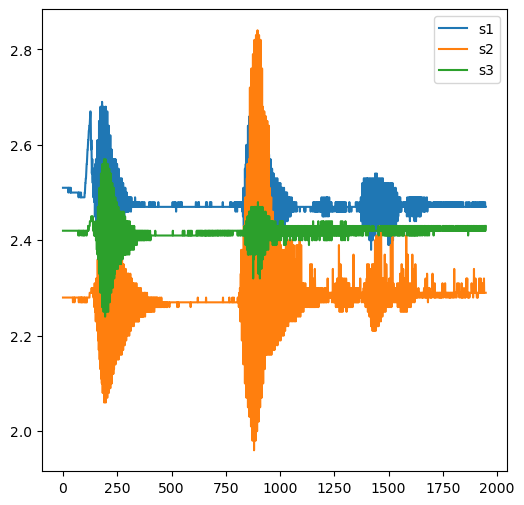

In [43]:
### Define constants
samples_to_capture = 1  # Number of samples to capture
serial_length = 2048  # Length of the serial comm message
n_sensors = 3  #  Number of sensors

### Initiate serial port communications
ser = serial.Serial('/dev/ttyACM0', baudrate=115200)
ser.flushInput()

### Clear data tensor
received_data = np.zeros([samples_to_capture,  # Define tensor to store captured data
                          n_sensors,
                          serial_length])

for i in range(samples_to_capture):
    for j in range(n_sensors):
        temp_data = []  # To store temporal data

        for k in range(serial_length):
            line = ser.readline()  # Read serial port input data
            if line:
                string = line.decode(errors='ignore') # Decode serial data
                temp_data.append(string.split('\r')[0])  # Save data to temporal storage
        
        temp_data = [2.5 if (len(data)!=4) else data for data in temp_data]  # Replace all the values with (len=!4) with 2.5 (avg value)
        received_data[i, j, :] = temp_data  # Move data from temporal storage to the tensor

ser.close()  # Close serial communiacations


sample = received_data[0][0][100:]
plt.plot(np.arange(0, len(sample)), sample, label = 's1')  # Plot the derivate function
sample = received_data[0][1][100:]
plt.plot(np.arange(0, len(sample)), sample, label = 's2')  # Plot the derivate function
sample = received_data[0][2][100:]
plt.plot(np.arange(0, len(sample)), sample, label = 's3')  # Plot the derivate function

plt.legend()
plt.show()

### Data cleaning and preparation

Output space indexes:  [33]
Output space indexes:  [33, 40, 62]
Output space indexes:  [32, 36]


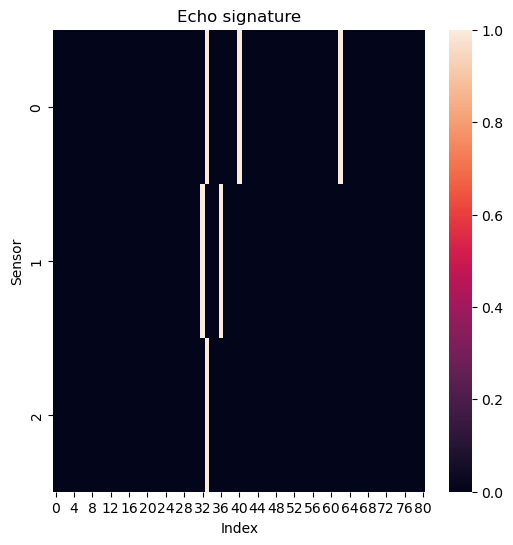

In [44]:
curated_data = np.zeros([samples_to_capture, n_sensors, 81])
plot_processing = False

for i in range(samples_to_capture):
    for j in range(n_sensors):
        
        ## Define sample to analize
        
        sample = received_data[i-1, j-1, 100:].astype(float)
        
        ## Apply derivate and noise reduction techniques
        
        sample_denoised = helpers.derivate_and_noise_reduction(sample, plot_processing)
       
        ## Detect pulses and retrieve related sample indexes
        
        center_point_pulse, center_point = helpers.pulse_detection(sample_denoised, plot_processing)

        ## Transform sample dimention to match ML algorithm input dimention
        
        output_space = helpers.dimention_transformation(center_point_pulse, center_point, print_results = True)
        
        ## Replace calculated indexes in the final array
        for pulse_idx in output_space:
            curated_data[i-1, j-1, pulse_idx] = 1

        print('Output space indexes: ',output_space)

    sns.heatmap(curated_data[i-1, :, :])
    plt.xlabel('Index')
    plt.ylabel('Sensor')
    plt.title('Echo signature')
    plt.show()

### Inference test

Load ML model

In [8]:
#load model from path
path_to_load = '../models/model_v2.h5'
#define needed dependecies to load the model
dependencies = {
    'f1_m': f1_m
}
#load the model
classifier = load_model(path_to_load, custom_objects=dependencies, compile=False )

Original input data shape:  (1, 3, 81)
New input data shape:  (1, 243)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Predicted object quadrant:  [ 53  77 114]


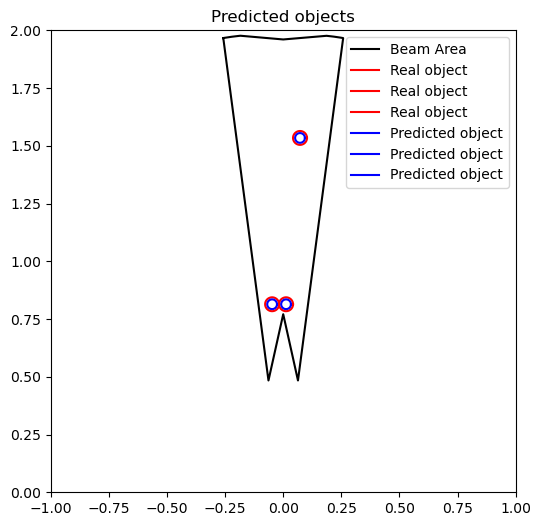

In [45]:
### Reshape 3D data into 2D array
print("Original input data shape: ", curated_data.shape)

model_input  = curated_data.reshape(curated_data.shape[0],
                      (curated_data.shape[1] * curated_data.shape[2]))

print("New input data shape: ", model_input.shape)

### Make predictions
X_val = model_input  #Values to predict

#define a threshold value 
threshold = 0.1
#ANN prediction
y_pred = classifier.predict(X_val)
#keep predictions above the threshold
y_pred = (y_pred > threshold)

for pred in range(len(y_pred)):

    print('\nPredicted object quadrant: ',
          np.argwhere(np.isin(y_pred[pred], True)).ravel())
    
    predicted_points = np.argwhere(np.isin(y_pred[pred], True)).ravel()



    plt.rcParams["figure.figsize"] = (6,6)
    object_location.test(predicted_points, predicted_points)


### Automate capture and inference

In [24]:
import capture_and_inference

In [25]:
#Load ML model
path_to_load = '../models/model_v2.h5'
model_classifier = capture_and_inference.load_ml_model(path_to_load)

Machine Learning model succesfully loaded!


In [28]:
samples_to_capture = 3 # Samples to capture
print_echo_signature = True # Print calculation results
serial_port = '/dev/ttyACM0'
capture_and_inference.capture_data(samples_to_capture,
                                   model_classifier,
                                   print_echo_signature,
                                   serial_port)

IndexError: index 84 is out of bounds for axis 2 with size 81